# XIA counter (Th-230 source) notebook
This notebook is a summary of the analysis for the Th-230 alpha source provided by XIA. The goals of the runs were to evaluate the performance/stability of the system when switching to a LAr boil-off for purging as well as evaluate the reduction in Radon background. 

**Source Description:** The source is a Th-230 sample (Produced by Eckert & Ziegler Analytics, Calibrated on August 21, 2007, SRS 75680-561) that was electrodeposited onto a stainless steel disk, with active diameter of 24.1 mm, attached to a silicon wafer. The activity of the source is 3.13 Bq (187.6 dpm) and the half-life of the source is 7.538xE4 years.

**Run description:** On 01/22/2018, began purging the system with N2 to dry the system, the source tray was open for an undetermined amount of time (probably day or two) before inserting the Th-230 source. On 01/23/2018, began the runs taking 6 45-minute runs, the system seemed faily unstable at this point probably because the purge wasn't long enough after leaving the system open for so long. Because the system didn't seem stable at the beginning of data-taking, I discarded the first 4 runs in the analysis. Starting from 01/24/2018 until 02/02/2018, took two 1-hour runs every weekday, one with the full electrode and one with the wafer electrode. 

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid', context='talk')

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [2]:
inDir = '/Users/brianzhu/AnacondaProjects/XIACounter/Data'
outDir = '/Users/brianzhu/AnacondaProjects/XIACounter/Plots'

In [3]:
# Load Data
dateList = ['01232018','01242018','01252018','01262018','01302018','01312018','02012018','02022018']
runList, runNameList = ['1','2'], ['Full', 'Wafer']
dfList, index, dtList = [], 0, []

for date in dateList:
    dateDT = datetime.strptime(date, '%m%d%Y')
    dtList.append(dateDT)
    for run in runList:    
        dfList.append(pd.read_csv('{}/AnalysisResults_{}_{}.csv'.format(inDir,date,run), header=11))
        # Add other information
        dfList[index]['Date'] = dateDT
        if run=='1':
            dfList[index]['Run Type'] = 'Full'
        elif run=='2':
            dfList[index]['Run Type'] = 'Wafer'
        # Create 'Risetime' variable, it's the Anode tR - Anode t0
        dfList[index]['RiseTime'] = dfList[index]['Anode tR (microseconds)'] - dfList[index]['Anode t0 (microseconds)']
        index += 1

df = pd.concat(dfList)

# Basic Run Information
Here I print out the first couple of events in the dataset, highlighting the different event properties (columns) and the unique types of event classifications

In [4]:
df.head()

,# Event ID,Trigger time (s),Event class,Anode amplitude (ADC),Anode energy (MeV),Anode t0 (microseconds),Anode tS (microseconds),Anode tR (microseconds),Date,Run Type,RiseTime
0,1,0.539,Alpha,2224.24428,4.89490,89.00000,139.66564,158.61926,2018-01-23,Full,69.61926
1,2,1.050,Alpha,2307.19676,5.15733,82.00000,137.71625,159.27021,2018-01-23,Full,77.27021
2,3,1.443,Alpha,2245.30362,5.21976,88.00000,135.35970,161.68214,2018-01-23,Full,73.68214
3,4,1.520,Alpha,2157.13822,4.77561,90.00000,136.64449,154.98315,2018-01-23,Full,64.98315
4,5,2.099,Alpha,2172.45368,4.47156,89.24485,145.88600,156.41321,2018-01-23,Full,67.16836


In [5]:
# Print out basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84964 entries, 0 to 5468
Data columns (total 11 columns):
# Event ID                 84964 non-null int64
Trigger time (s)           84964 non-null float64
Event class                84964 non-null object
Anode amplitude (ADC)      84964 non-null float64
Anode energy (MeV)         84964 non-null float64
Anode t0 (microseconds)    84688 non-null float64
Anode tS (microseconds)    84688 non-null float64
Anode tR (microseconds)    84688 non-null float64
Date                       84964 non-null datetime64[ns]
Run Type                   84964 non-null object
RiseTime                   84688 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1), object(2)
memory usage: 7.8+ MB


# Event class types
Looking at unique types in "Event class", there are 7 different classes. For our study we will only focus on "Alpha" and "MidAir" data types. "MidAir" event types are typically background events with a slower RiseTime but can also be true alpha events that are misclassified.

In [6]:
print(np.unique(df['Event class']))

['Alpha' 'Ceiling' 'Error' 'MidAir' 'NegativeCharge' 'Noise' 'Round'
 'Sidewall' 'SlowHigh']


# Energy Spectra
Here I draw a preliminary Energy spectrum for each Date (Row) and Run Type (column). For all of the following plots, I select only events that are classified as Alpha or MidAir (since we suspect some MidAir events to be alpha events that are simply mis-tagged).

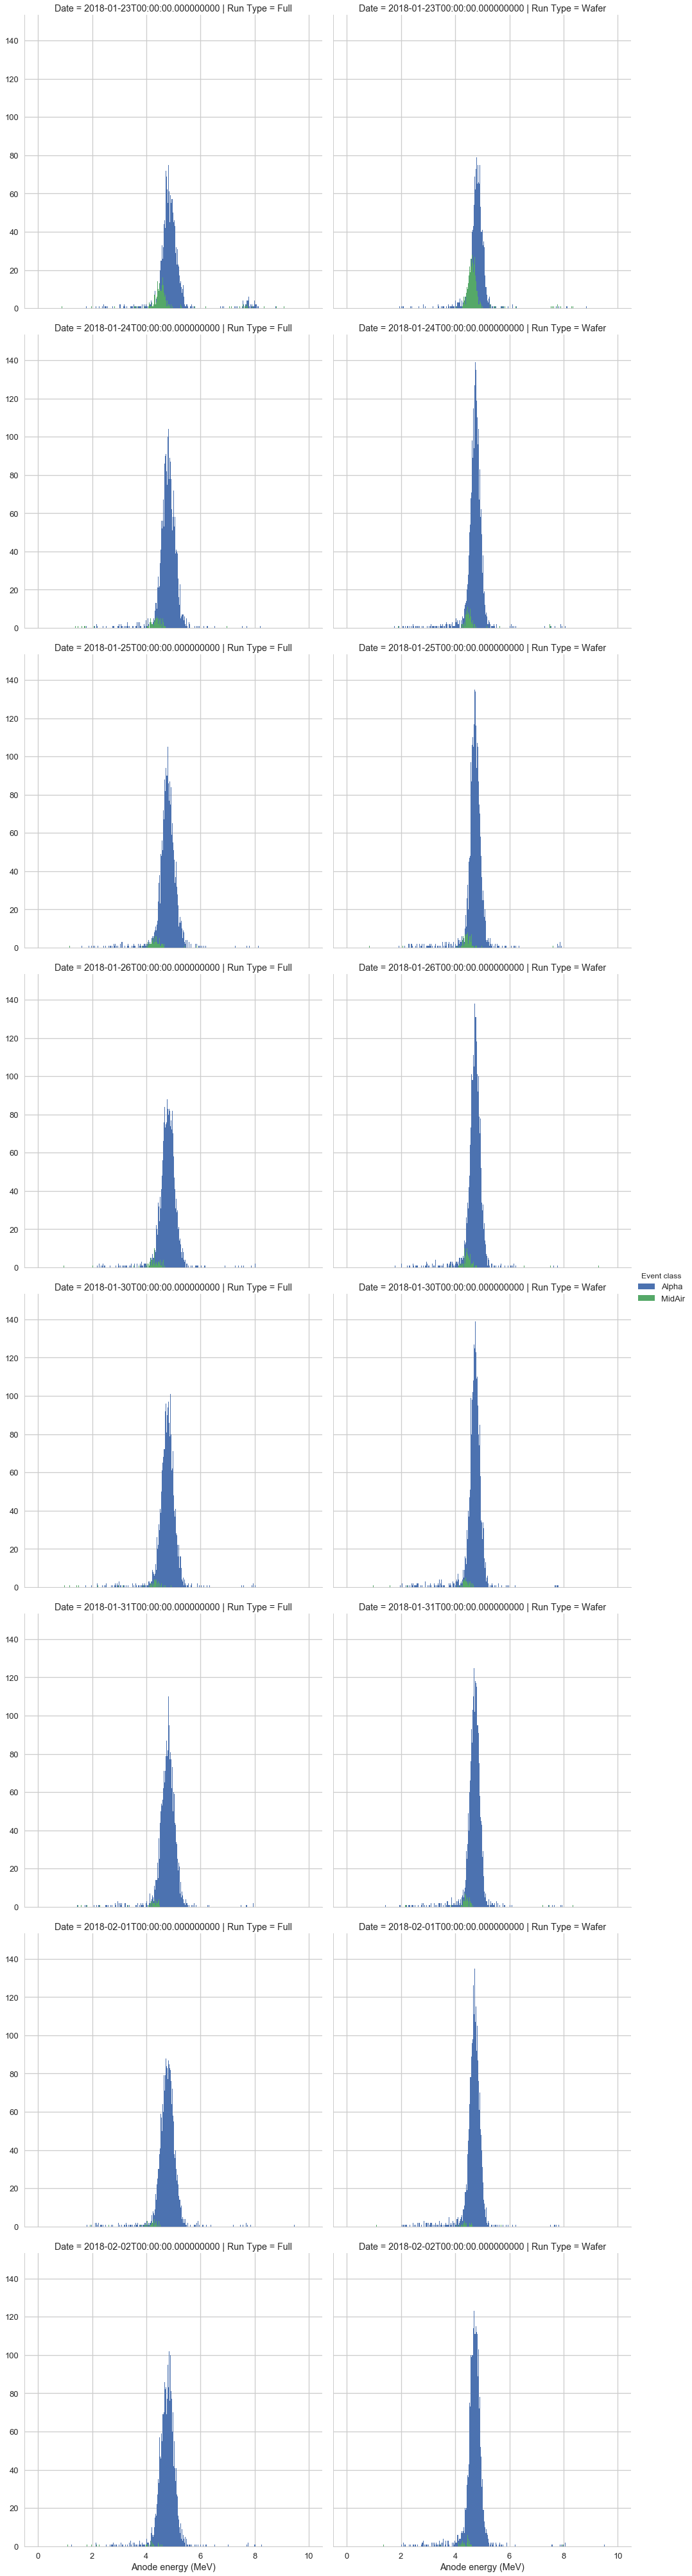

In [7]:
dfCut = df.loc[(df['Event class']=='Alpha') | (df['Event class']=='MidAir')]
xBins0 = np.linspace(0,10,1000)
g0 = sns.FacetGrid(data=dfCut, size=7, hue='Event class', col='Run Type', row='Date')
g0 = g0.map(plt.hist, 'Anode energy (MeV)', bins=xBins0).add_legend()

# RiseTime vs Energy distributions
In this section I draw the RiseTime (microseconds) vs Energy (MeV) distributions across Date (Row) and Run Type (column).

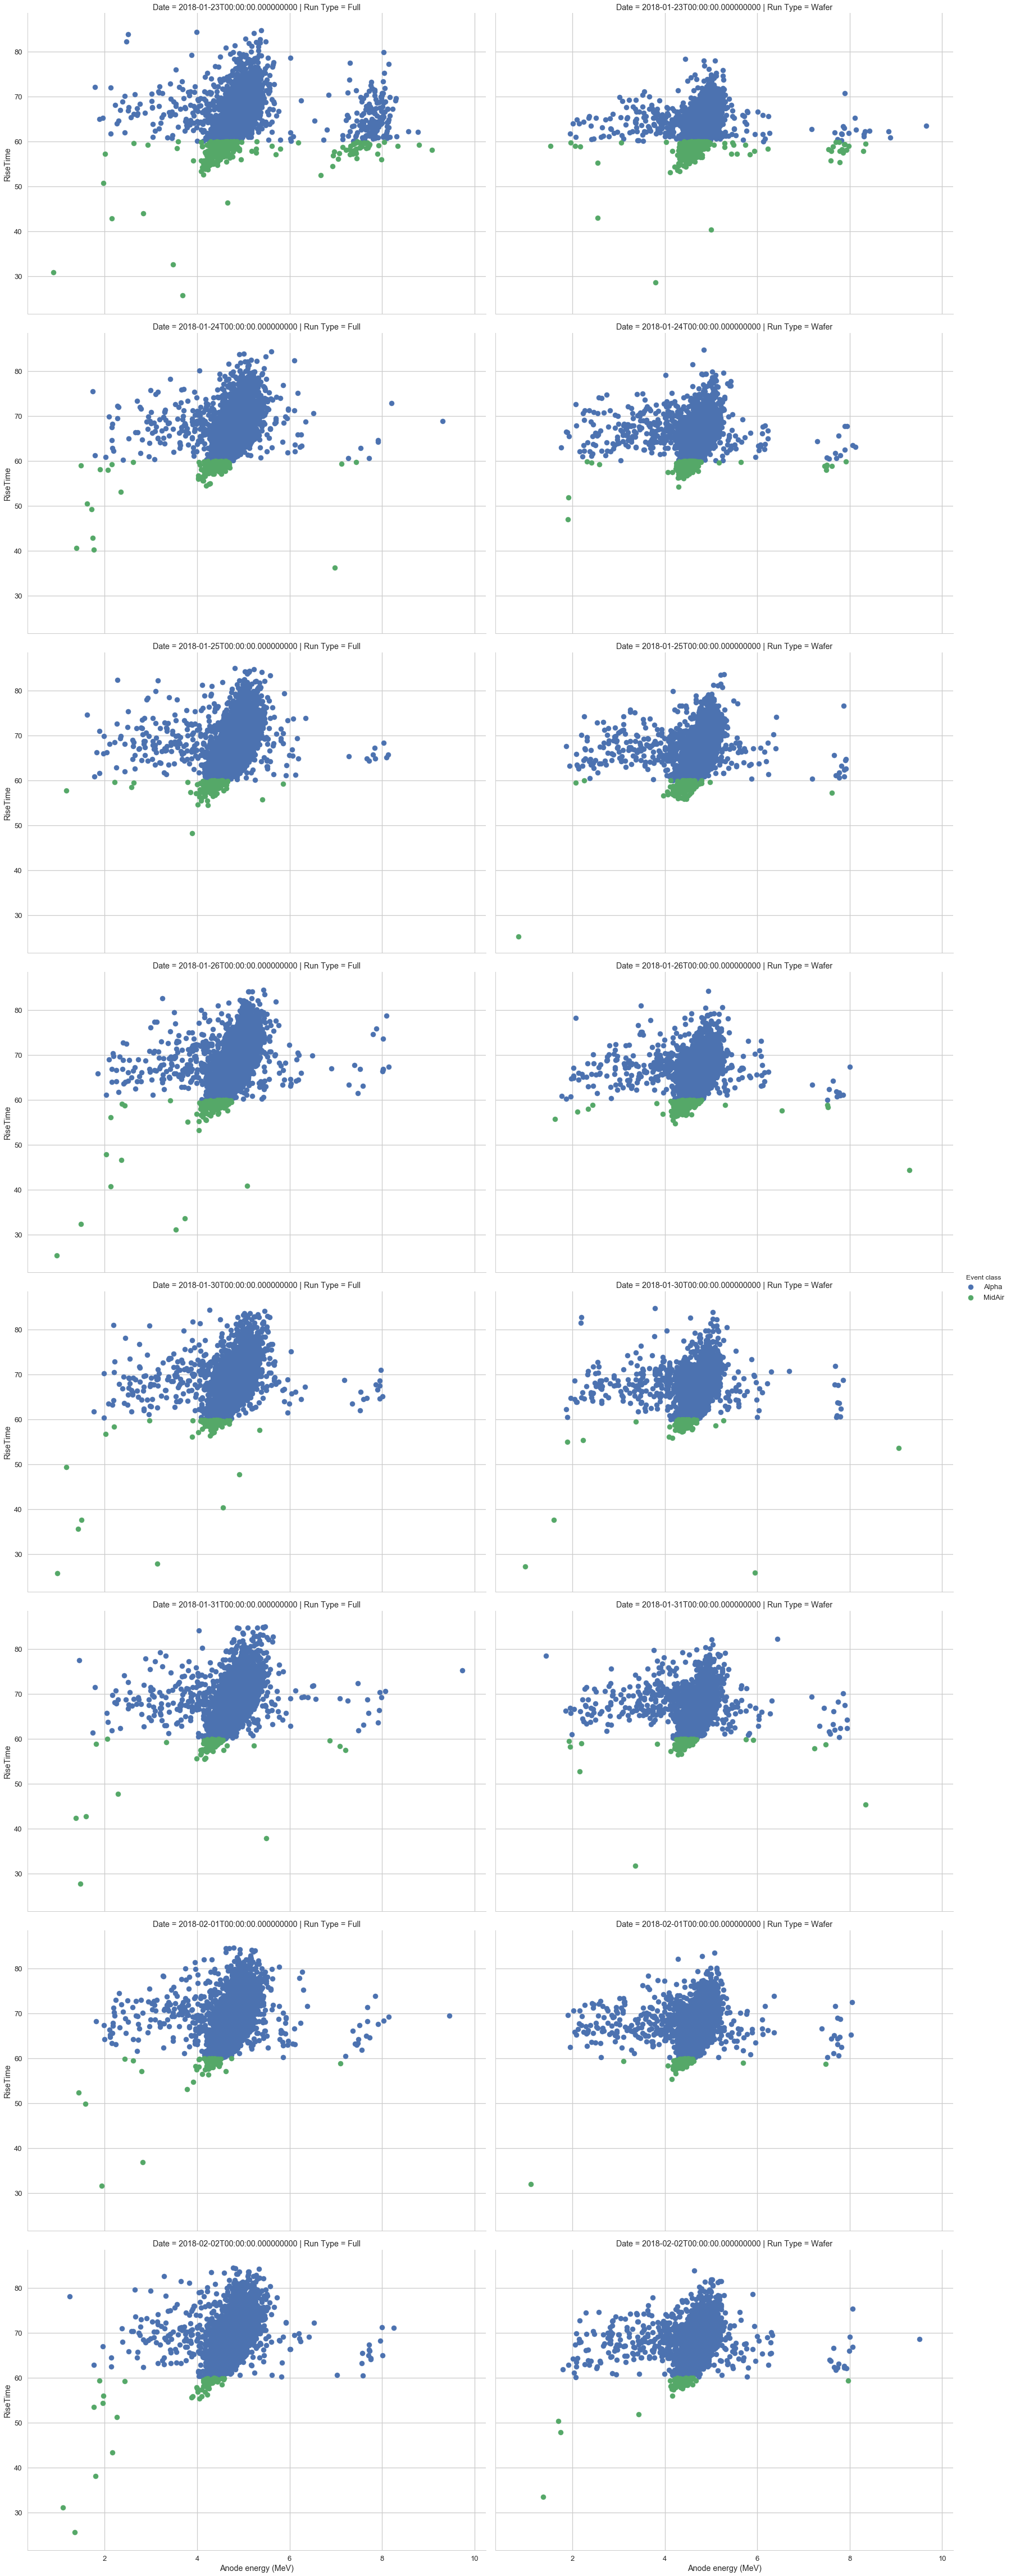

In [8]:
g1 = sns.FacetGrid(data=dfCut, size=8, aspect=1.5, row='Date', col='Run Type', hue='Event class')
g1 = g1.map(plt.scatter, 'Anode energy (MeV)', 'RiseTime').add_legend()

# Energy Spectra (Zoomed)
Here I zoom in on the Th-230 source peak between 3 and 6 MeV. The histograms are split by Date (Row) and Run Type (Column). Each histogram is further split by event type (Alpha and MidAir) and each event type is fit separately with a Gaussian. 


2018-01-23 00:00:00 (Full) Alpha Fit: Amp: 183.085683789 -- Mu: 4.85720614733 -- Sigma: 0.222979574864 
2018-01-23 00:00:00 (Full) MidAir Fit: Amp: 31.4153526677 -- Mu: 4.53426361668 -- Sigma: 0.167930315257 
2018-01-23 00:00:00 (Wafer) Alpha Fit: Amp: 225.720900377 -- Mu: 4.82885974906 -- Sigma: -0.157329958531 
2018-01-23 00:00:00 (Wafer) MidAir Fit: Amp: 72.760367542 -- Mu: 4.61882717022 -- Sigma: 0.135766548374 
2018-01-24 00:00:00 (Full) Alpha Fit: Amp: 263.424402916 -- Mu: 4.8126380633 -- Sigma: -0.22660596273 
2018-01-24 00:00:00 (Full) MidAir Fit: Amp: 13.8229099303 -- Mu: 4.38912214375 -- Sigma: 0.153697484339 
2018-01-24 00:00:00 (Wafer) Alpha Fit: Amp: 355.605925087 -- Mu: 4.75199832511 -- Sigma: 0.165655113555 
2018-01-24 00:00:00 (Wafer) MidAir Fit: Amp: 24.9617809539 -- Mu: 4.48494515812 -- Sigma: -0.122285585383 
2018-01-25 00:00:00 (Full) Alpha Fit: Amp: 265.534877337 -- Mu: 4.80357428804 -- Sigma: -0.225992874805 
2018-01-25 00:00:00 (Full) MidAir Fit: Amp: 12.51785526

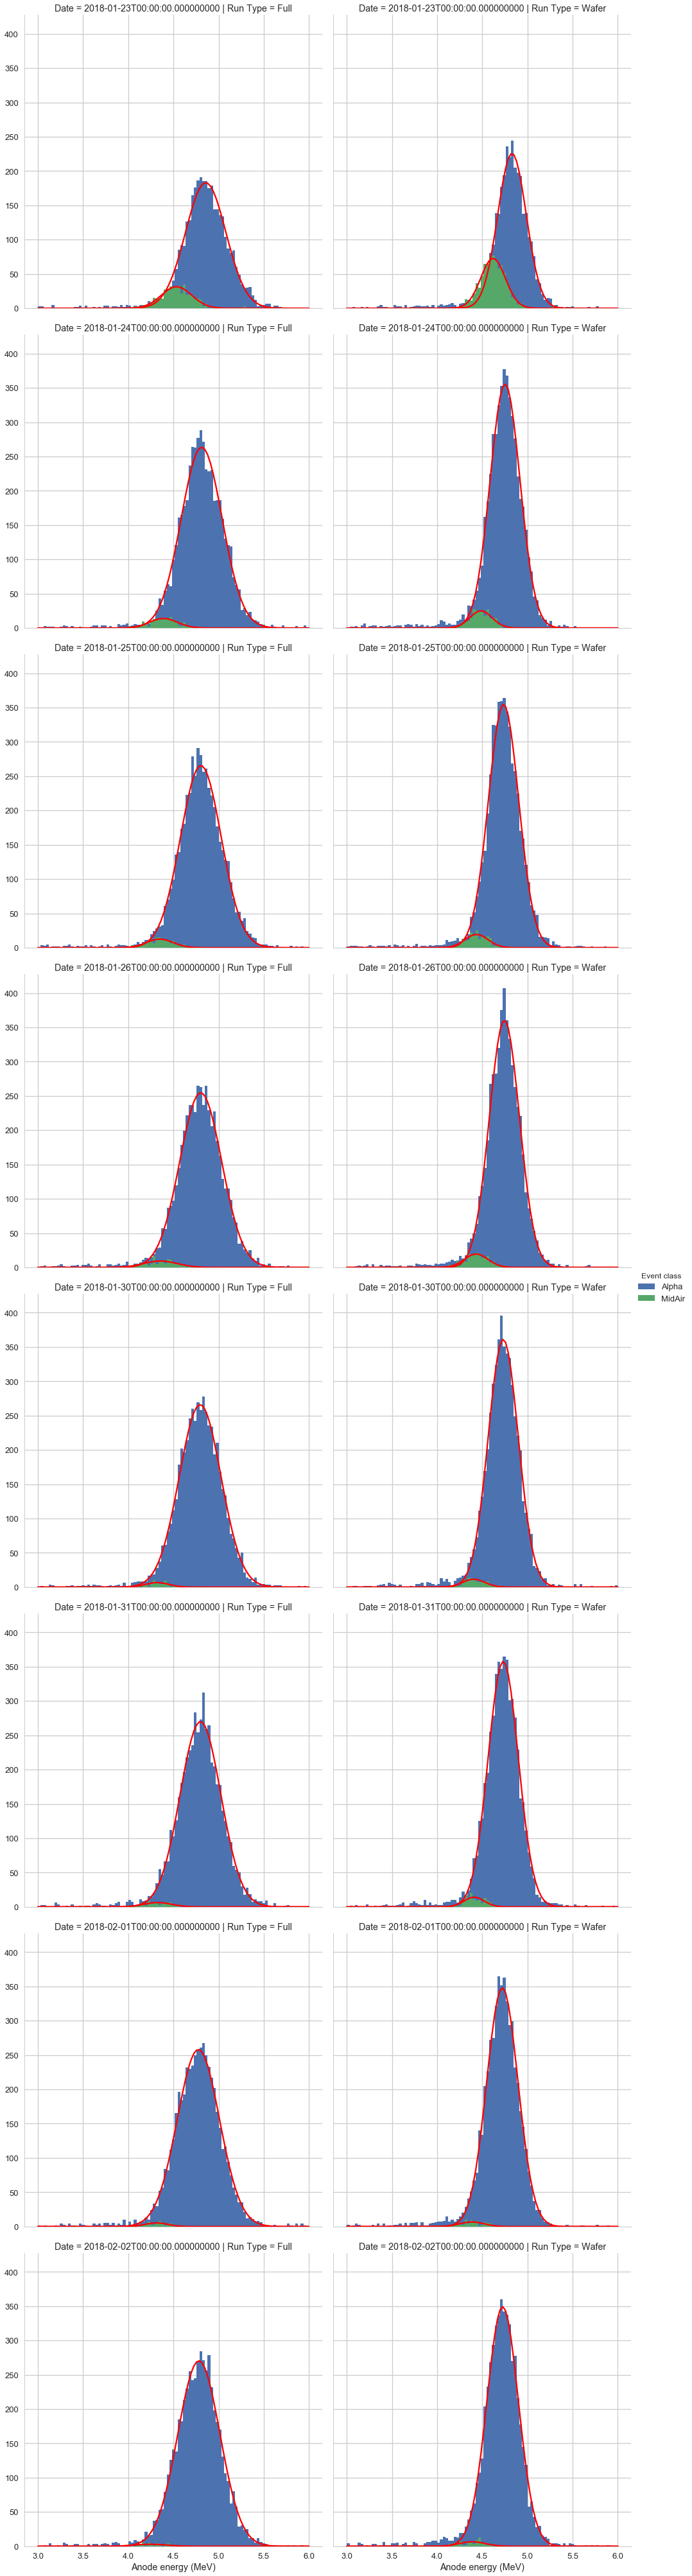

In [9]:
xBins = np.linspace(3,6,100)
g2 = sns.FacetGrid(data=dfCut, size=7, hue='Event class', col='Run Type', row='Date')
g2 = g2.map(plt.hist, 'Anode energy (MeV)', bins=xBins).add_legend()

for idx1, dateDT in enumerate(dtList):
    for idx2, runType in enumerate(runNameList):
        yBinsAlpha = np.histogram(dfCut['Anode energy (MeV)'].loc[(dfCut['Event class'] == 'Alpha') & (dfCut['Date'] == dateDT) & (dfCut['Run Type'] == runType) ].values, 100, range=(3,6) )
        yBinsMidAir = np.histogram(dfCut['Anode energy (MeV)'].loc[(dfCut['Event class'] == 'MidAir') & (dfCut['Date'] == dateDT) & (dfCut['Run Type'] == runType) ].values, 100, range=(3,6) )
        popta,pcova = curve_fit(gaus, xBins, yBinsAlpha[0])
        poptm,pcovm = curve_fit(gaus, xBins, yBinsMidAir[0])
        print('{} ({}) Alpha Fit: Amp: {} -- Mu: {} -- Sigma: {} '.format(dateDT, runType, *popta))
        print('{} ({}) MidAir Fit: Amp: {} -- Mu: {} -- Sigma: {} '.format(dateDT, runType, *poptm))
        g2.axes[idx1][idx2].plot(xBins, gaus(xBins, *popta), color='r')
        g2.axes[idx1][idx2].plot(xBins, gaus(xBins, *poptm), color='r')

# MidAir/Total Events Ratio vs Date
Here I count the number of MidAir and Total Events (MidAir + Alpha) between 3 to 6 MeV, take the ratio of MidAir/Total Events, and plot it against the run date


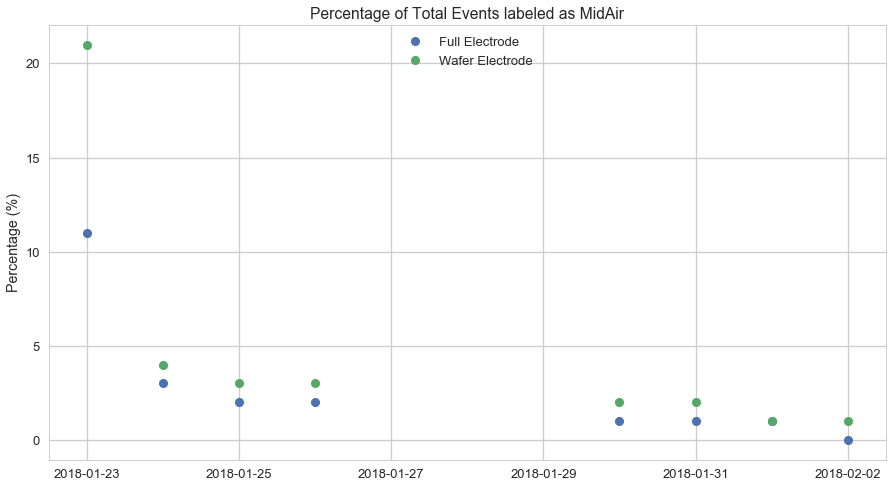

In [10]:
ratio = []
for idx1, dateDT in enumerate(dtList):
    for idx2, runType in enumerate(runNameList):
        nMidAir = len(dfCut['Anode energy (MeV)'].loc[(dfCut['Anode energy (MeV)'] > 3.) & (dfCut['Anode energy (MeV)'] < 6.) & (dfCut['Event class'] == 'MidAir') & (dfCut['Date'] == dateDT) & (dfCut['Run Type'] == runType)])
        nTotal = nMidAir + len(dfCut['Anode energy (MeV)'].loc[(dfCut['Anode energy (MeV)'] > 3.) & (dfCut['Anode energy (MeV)'] < 6.) & (dfCut['Event class'] == 'Alpha') & (dfCut['Date'] == dateDT) & (dfCut['Run Type'] == runType)])
        ratio.append(100*nMidAir/nTotal)
#         print(nMidAir, nTotal, 100.*nMidAir/nTotal)
        
fig0, ax0 = plt.subplots(figsize = (15,8))
ax0.plot(np.array(dtList), np.array(ratio)[::2], "o", label='Full Electrode')
ax0.plot(np.array(dtList), np.array(ratio)[1::2], "o", label='Wafer Electrode')
ax0.set_title('Percentage of Total Events labeled as MidAir')
ax0.set_ylabel('Percentage (%)')
ax0.legend(loc='upper center')

# Alpha Rate vs Date
Similar to the above, except I take only the number of counts in the alpha blob and plot against time. The nominal rate should be 90 cpm. 

**Note:** The first two runs on 01/23/2018 were 45 minutes instead of 60 minutes

2018-01-23 00:00:00 Full Alpha Rate: 58.4833333333 +/- 0.987280214641
2018-01-23 00:00:00 Wafer Alpha Rate: 52.0166666667 +/- 0.931098514898
2018-01-24 00:00:00 Full Alpha Rate: 84.4 +/- 1.18602979164
2018-01-24 00:00:00 Wafer Alpha Rate: 85.0 +/- 1.19023807142
2018-01-25 00:00:00 Full Alpha Rate: 85.7 +/- 1.1951290028
2018-01-25 00:00:00 Wafer Alpha Rate: 85.9166666667 +/- 1.19663881119
2018-01-26 00:00:00 Full Alpha Rate: 84.1166666667 +/- 1.18403734926
2018-01-26 00:00:00 Wafer Alpha Rate: 86.85 +/- 1.20312094155
2018-01-30 00:00:00 Full Alpha Rate: 86.6666666667 +/- 1.20185042515
2018-01-30 00:00:00 Wafer Alpha Rate: 86.6666666667 +/- 1.20185042515
2018-01-31 00:00:00 Full Alpha Rate: 86.9166666667 +/- 1.20358261499
2018-01-31 00:00:00 Wafer Alpha Rate: 85.85 +/- 1.19617445773
2018-02-01 00:00:00 Full Alpha Rate: 85.2333333333 +/- 1.19187061192
2018-02-01 00:00:00 Wafer Alpha Rate: 86.6 +/- 1.20138808606
2018-02-02 00:00:00 Full Alpha Rate: 89.0166666667 +/- 1.21803575937
2018-02-0

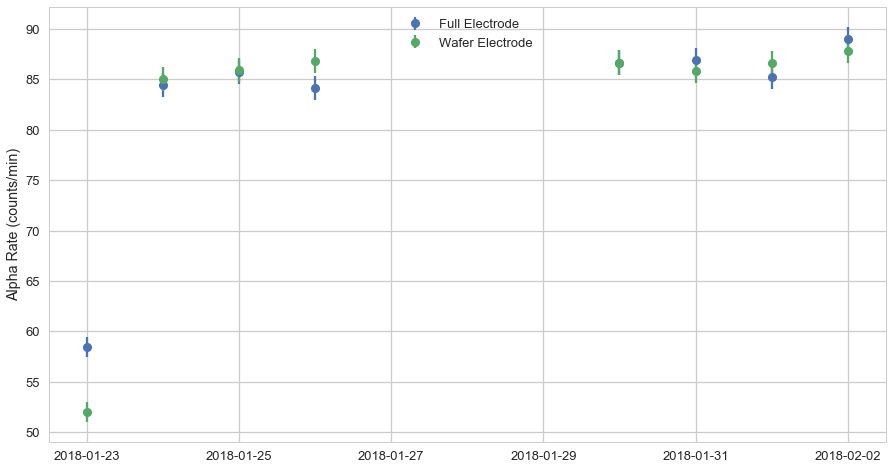

In [15]:
alphaRate = []
alphaRateErr = []
for idx1, dateDT in enumerate(dtList):
    for idx2, runType in enumerate(runNameList):
        nAlpha = len(dfCut['Anode energy (MeV)'].loc[(dfCut['Anode energy (MeV)'] > 3.) & (dfCut['Anode energy (MeV)'] < 6.) & (dfCut['Event class'] == 'Alpha') & (dfCut['Date'] == dateDT) & (dfCut['Run Type'] == runType)])
        if dateDT == '2018-01-23':
            alphaRate.append(nAlpha/45.)
            alphaRateErr.append(np.sqrt(nAlpha)/45.)
            print("{} {} Alpha Rate: {} +/- {}".format(dateDT, runType, nAlpha/45., np.sqrt(nAlpha)/45.))
        else:
            alphaRate.append(nAlpha/60.)
            alphaRateErr.append(np.sqrt(nAlpha)/60.)
            print("{} {} Alpha Rate: {} +/- {}".format(dateDT, runType, nAlpha/60., np.sqrt(nAlpha)/60.))
            
fig1, ax1 = plt.subplots(figsize = (15,8))
ax1.errorbar(np.array(dtList), np.array(alphaRate)[::2],yerr=np.array(alphaRateErr)[::2], fmt="o", label='Full Electrode')
ax1.errorbar(np.array(dtList), np.array(alphaRate)[1::2], yerr=np.array(alphaRateErr)[::2], fmt="o", label='Wafer Electrode')
ax1.set_ylabel('Alpha Rate (counts/min)')
ax1.legend(loc='upper center')

# RiseTime histogram distribution
Draw RiseTime histogram between 4.25 and 5.25 MeV (to select the Th-230 events) and fit with a Gaussian

2018-01-23 00:00:00 (Full) RiseTime Fit: Amp: 192.204355103 -- Mu: 63.8550840542 -- Sigma: 3.74098131788 
2018-01-23 00:00:00 (Wafer) RiseTime Fit: Amp: 249.424465949 -- Mu: 61.944658655 -- Sigma: 3.04307939456 
2018-01-24 00:00:00 (Full) RiseTime Fit: Amp: 271.82329284 -- Mu: 65.7806072241 -- Sigma: 3.58522405111 
2018-01-24 00:00:00 (Wafer) RiseTime Fit: Amp: 333.331647565 -- Mu: 64.5063941652 -- Sigma: 3.11604818632 
2018-01-25 00:00:00 (Full) RiseTime Fit: Amp: 267.322220563 -- Mu: 66.169606954 -- Sigma: 3.66364510308 
2018-01-25 00:00:00 (Wafer) RiseTime Fit: Amp: 320.111749768 -- Mu: 64.8016728739 -- Sigma: 3.21056076673 
2018-01-26 00:00:00 (Full) RiseTime Fit: Amp: 266.981995649 -- Mu: 66.2417638755 -- Sigma: 3.58087382274 
2018-01-26 00:00:00 (Wafer) RiseTime Fit: Amp: 331.864630001 -- Mu: 65.0204677454 -- Sigma: 3.14317542858 
2018-01-30 00:00:00 (Full) RiseTime Fit: Amp: 271.373175502 -- Mu: 67.0543015945 -- Sigma: 3.66484824712 
2018-01-30 00:00:00 (Wafer) RiseTime Fit: Amp

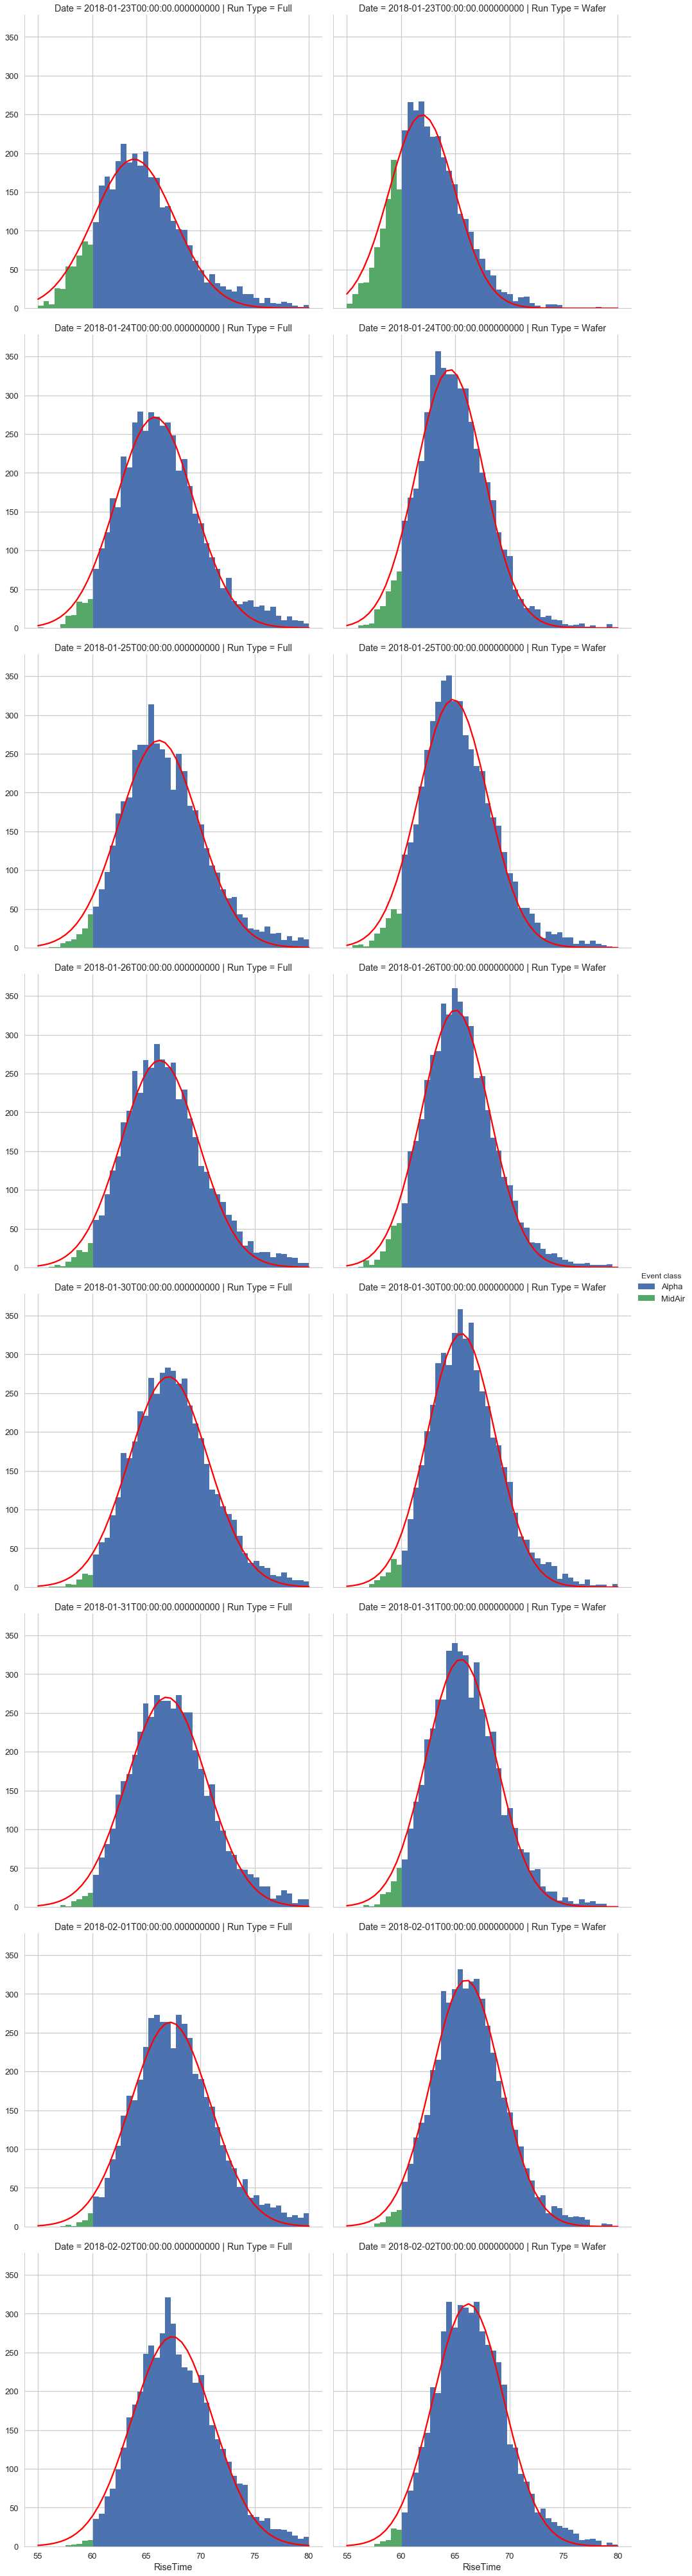

In [12]:
rBins = np.linspace(55,80,50)
g3 = sns.FacetGrid(data=dfCut.loc[(dfCut['Anode energy (MeV)'] > 4.25) & (dfCut['Anode energy (MeV)'] < 5.25)], size=7, hue='Event class', col='Run Type', row='Date')
g3 = g3.map(plt.hist, 'RiseTime', bins=rBins).add_legend()

rtTrend = []
sgTrend = []

for idx1, dateDT in enumerate(dtList):
    for idx2, runType in enumerate(runNameList):
        yRiseTime = np.histogram(dfCut['RiseTime'].loc[(dfCut['Anode energy (MeV)'] > 4.25) & (dfCut['Anode energy (MeV)'] < 5.25) & (dfCut['Date'] == dateDT) & (dfCut['Run Type'] == runType)].values, 50, range=(55,80) )
        # This fit does better with some basic bounds
        poptr,pcovr = curve_fit(gaus, rBins, yRiseTime[0], bounds=(0., [1000., 80., 50]))
        print('{} ({}) RiseTime Fit: Amp: {} -- Mu: {} -- Sigma: {} '.format(dateDT, runType, *poptr))
        rtTrend.append(poptr[1])
        sgTrend.append(poptr[2])
        g3.axes[idx1][idx2].plot(rBins, gaus(rBins, *poptr), color='r')

# RiseTime Trend
Here I plot the trend of RiseTime vs Date using the fitted Gaussian centroid and sigma values

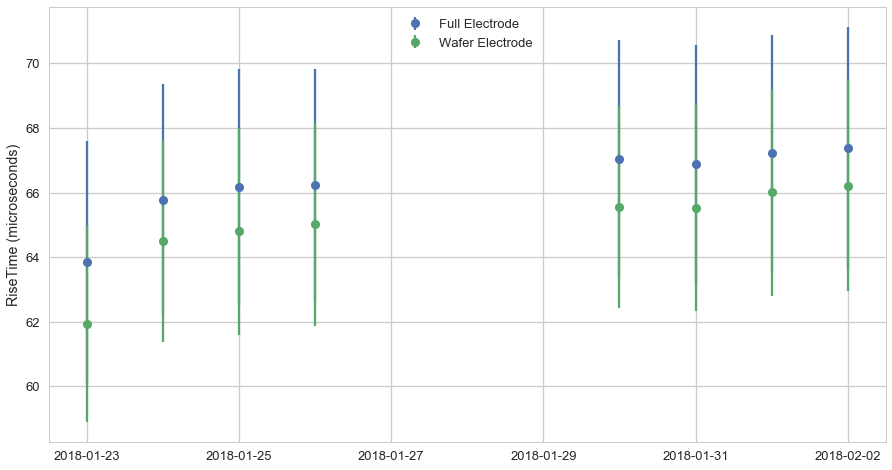

In [13]:
rtArr = np.array(rtTrend)
sgArr = np.array(sgTrend)

fig2, ax2 = plt.subplots(figsize = (15,8))
ax2.errorbar(np.array(dtList), rtArr[::2], yerr=sgArr[::2], fmt="o", label='Full Electrode')
ax2.errorbar(np.array(dtList), rtArr[1::2], yerr=sgArr[1::2], fmt="o", label='Wafer Electrode')
ax2.set_ylabel('RiseTime (microseconds)')
ax2.legend(loc='upper center')

# Radon Background
I tag events as Radon if their energies are between 6.5 and 10 MeV and they're tagged as Alpha or MidAir. A more thorough analysis of the ambient background will be performed in the future.

**Note:** the first two runs were 45 minutes so to convert to counts/minute I divide by 45 minutes instead of 60

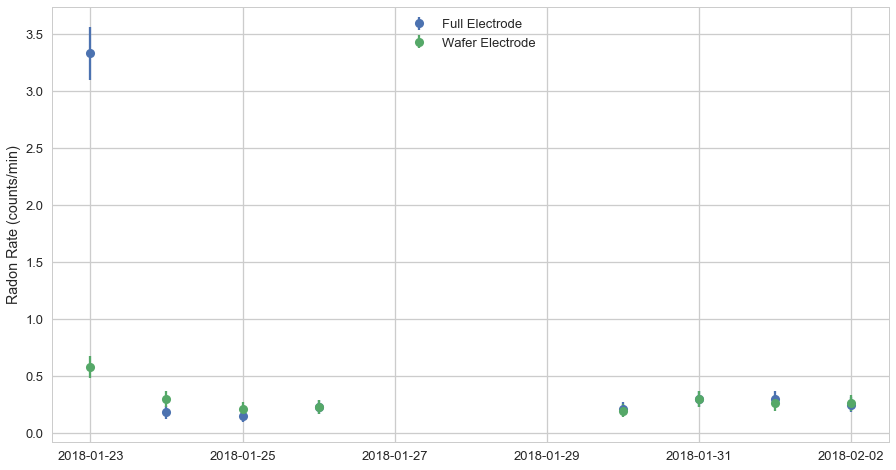

In [14]:
radonRate = []
radonRateErr = []
for idx1, dateDT in enumerate(dtList):
    for idx2, runType in enumerate(runNameList):
        nRadon = len(dfCut['Anode energy (MeV)'].loc[(dfCut['Anode energy (MeV)'] > 6.5) & (dfCut['Anode energy (MeV)'] < 10.) & (dfCut['Date'] == dateDT) & (dfCut['Run Type'] == runType)])
        if dateDT == '2018-01-23':
            radonRate.append(nRadon/45.)
            radonRateErr.append(np.sqrt(nRadon)/45.)
        else:
            radonRate.append(nRadon/60.)
            radonRateErr.append(np.sqrt(nRadon)/60.)
        
fig3, ax3 = plt.subplots(figsize = (15,8))
ax3.errorbar(np.array(dtList), np.array(radonRate)[::2], yerr=np.array(radonRateErr)[::2], fmt="o", label='Full Electrode')
ax3.errorbar(np.array(dtList), np.array(radonRate)[1::2], yerr=np.array(radonRateErr)[1::2], fmt="o", label='Wafer Electrode')
ax3.set_ylabel('Radon Rate (counts/min)')
ax3.legend(loc='upper center')

# Summary
We performed a preliminary analysis of the Th-230 source provided by XIA. We found that the system stabilizes within one week after leaving the source tray open the tray for an unknown amount of time (on the order of one week). We measured the alpha source activity to be 89 +/- 1.2 cpm, exponentially approaching the 90 cpm +/- 2.8 cpm activity measured by XIA. These measurements strongly suggests that the location of the XIA counter at LANL is having a negligible effect on the operation of the counter.

We also performed a preliminary study of the ambient radon background contamination. The ambient radon background also plateaus within the first week.